In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import scipy
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Data standard scaler
from sklearn.preprocessing import StandardScaler

# Random train-test split
from sklearn.model_selection import train_test_split

# Metrics and model selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import ttest_ind

from networkx.algorithms import bipartite

#To visualize on of the RandomForest decision trees
#from sklearn import tree

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the data
<a class="anchor" id="load"></a>

In [3]:
DATA_PATH = './preprocessed_data'
MOVIE_PATH = os.path.join(DATA_PATH, 'american_movies_preprocessed.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'characters_preprocessed.tsv')
SCORE_PATH = os.path.join(DATA_PATH, 'score_function.tsv')

### 1.1 Characters data
<a class="anchor" id="load_characters"></a>

In [4]:
df_chars=pd.read_csv(CHAR_PATH, sep="\t")
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')
df_chars['min_year'].fillna(0, inplace=True)
df_chars.head(2)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,m_genre_PCA,m_release_year,min_year
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,Ghosts of Mars,"Documentary, Culture & Society, Gay, Gay Interest",2001,0.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,Ghosts of Mars,"Documentary, Culture & Society, Gay, Gay Interest",2001,2000.0


### 1.2 The data score

In [5]:
df_numbers=pd.read_csv(SCORE_PATH, sep='\t').set_index('actor_name')
df_numbers.reset_index(inplace=True)
df_numbers.drop(['min_year'], axis=1, inplace=True)
df_numbers.head(2)

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,min_year_score
0,Jane Fonda,99.0,346.5,181.5,123.75,94.050000,75.900000,441.642857,243.803571,174.125000,...,36.229737,892.587692,462.089744,317.717532,244.955719,200.891379,171.213548,149.784285,133.531250,0
1,Clint Eastwood,348.0,174.0,460.0,729.00,1755.266667,1706.666667,1880.347619,1189.833333,1686.509524,...,3219.994472,2139.009068,1715.610398,1470.104342,3616.394846,2334.278040,1850.068876,1576.740235,1825.545952,0


# 2.1 Dataset preparation

In [6]:
df_chars_merged = df_chars.merge(df_numbers, on='actor_name', how='left').copy()
numbers_columns = df_numbers.columns[1:]
df_chars_merged[numbers_columns] = df_chars_merged[numbers_columns].fillna(0)
df_chars_merged['min_year'] = df_chars_merged['min_year'].astype('int')
df_chars_merged.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,min_year_score
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,Ghosts of Mars,...,34.200000,28.500000,24.428571,21.375000,19.000000,17.100000,15.545455,14.250000,13.153846,0.0
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,Ghosts of Mars,...,2146.828571,3255.369913,1990.897222,2641.254319,2432.196392,1729.285333,1391.918606,1179.534513,1029.515124,0.0
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,Ghosts of Mars,...,477.600000,715.333333,426.228571,311.050000,930.650794,546.942857,2009.549784,1152.650000,2576.304895,0.0
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,Ghosts of Mars,...,388.000000,261.583333,197.888889,159.400000,133.575758,115.023810,101.038462,90.111111,81.333333,0.0


In [7]:
nb_actors = df_chars_merged['actor_name'].nunique()
print("There are {} actors in this dataset.".format(nb_actors))

There are 34388 actors in this dataset.


In [8]:
df_chars_merged['is_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] == row['m_release_date'].year, axis=1).astype(int)
df_chars_merged['already_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] < row['m_release_date'].year and row['min_year']!=0, axis=1).astype(int)
df_chars_merged.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2006,2007,2008,2009,2010,2011,2012,min_year_score,is_revealed,already_revealed
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,Ghosts of Mars,...,24.428571,21.375000,19.000000,17.100000,15.545455,14.250000,13.153846,0.0,0,1
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,Ghosts of Mars,...,1990.897222,2641.254319,2432.196392,1729.285333,1391.918606,1179.534513,1029.515124,0.0,0,1
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,Ghosts of Mars,...,426.228571,311.050000,930.650794,546.942857,2009.549784,1152.650000,2576.304895,0.0,0,1
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,Ghosts of Mars,...,197.888889,159.400000,133.575758,115.023810,101.038462,90.111111,81.333333,0.0,0,1


<AxesSubplot:>

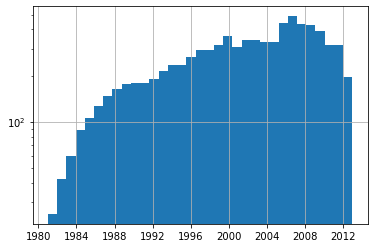

In [35]:
grouped = df_chars_merged.groupby(['wikipedia_m_ID', 'm_release_date'])['already_revealed'].sum().reset_index()

grouped[grouped['already_revealed'] > 0]['m_release_date'].hist(bins=33, log=True)

<AxesSubplot:>

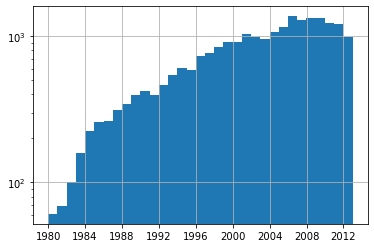

In [34]:
df_chars_merged.loc[(df_chars_merged['already_revealed']==1) | (df_chars_merged['is_revealed']==1)]['m_release_date'].hist(bins=33, log=True)

# 2.2 Movies that have a revelation

In [9]:
df_movie_revelation = df_chars_merged.groupby(['wikipedia_m_ID', 'm_release_date', 'm_genre_PCA']).agg({'is_revealed': 'sum', 'already_revealed':'sum'}).copy().reset_index()
df_movie_revelation['m_release_year'] = df_movie_revelation['m_release_date'].dt.year
df_movie_revelation.rename({'is_revealed' : 'has_revelation', 'already_revealed' : 'has_famous_actors'}, axis=1, inplace=True)
df_movie_revelation['has_revelation'] = (df_movie_revelation['has_revelation'] > 0).astype(int)
df_movie_revelation.head()

,wikipedia_m_ID,m_release_date,m_genre_PCA,has_revelation,has_famous_actors,m_release_year
0,3217,1992-10-09,"Gross-out film, Gross out, Romance Film, Comedy",1,0,1992
1,3333,1915-01-01,"Environmental Science, Nature, Sword and sorce...",0,0,1915
2,3746,1982-06-25,"Doomsday film, Apocalyptic and post-apocalypti...",1,1,1982
3,3837,1974-02-07,"Horror, B-movie, Cult, Slasher",0,0,1974
4,3947,1986-08-01,"Detective, Detective fiction, Crime Thriller, ...",0,1,1986


In [10]:
df_movie_revelation['has_revelation'].value_counts()

0    22991
1     1859
Name: has_revelation, dtype: int64

In [11]:
nb_movies = df_movie_revelation['wikipedia_m_ID'].nunique()
nb_movies_revelation = df_movie_revelation['has_revelation'].value_counts()[1]
print("There are {} movies with a revelation which represents {:.2f}% of the movies.".format(nb_movies_revelation, nb_movies_revelation*100/nb_movies))
#df_movie_revelation = df_movie_revelation.loc[(df_movie_revelation['has_revelation'] > 0)]

There are 1859 movies with a revelation which represents 7.48% of the movies.


In [12]:
nb_movies_with_famous_actor = df_movie_revelation.loc[(df_movie_revelation['has_famous_actors']>0) & (df_movie_revelation['has_revelation']>0)].shape[0]
print("Among movies with a revelation, there are {} movies with at least one famous actor which represents {:.2f}% of the movies with revelation.".format(nb_movies_with_famous_actor, nb_movies_with_famous_actor*100/nb_movies_revelation))

Among movies with a revelation, there are 1490 movies with at least one famous actor which represents 80.15% of the movies with revelation.


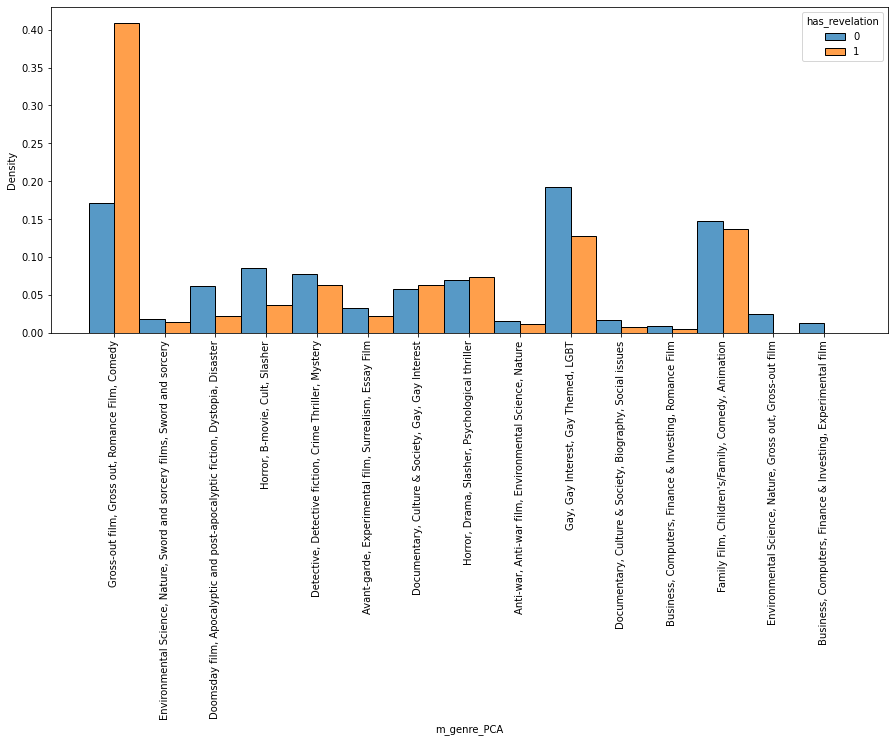

In [13]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df_movie_revelation, x='m_genre_PCA', hue='has_revelation', multiple="dodge", stat='density', common_norm=False)
plt.xticks(rotation=90);

In [14]:
#For the movie with no famous actor, the revelation must come from another factor than co-acting.
#Therefore, we decided to only focus on movies that had at least one actor, to analyse co-acting impact.
df_movie_revelation = df_movie_revelation.loc[(df_movie_revelation['has_famous_actors'] > 0)]
df_movie_revelation.head()

,wikipedia_m_ID,m_release_date,m_genre_PCA,has_revelation,has_famous_actors,m_release_year
2,3746,1982-06-25,"Doomsday film, Apocalyptic and post-apocalypti...",1,1,1982
4,3947,1986-08-01,"Detective, Detective fiction, Crime Thriller, ...",0,1,1986
6,4231,1992-07-31,"Horror, B-movie, Cult, Slasher",0,2,1992
7,4560,1995-05-18,"Gross-out film, Gross out, Romance Film, Comedy",0,1,1995
8,4726,1989-06-19,"Avant-garde, Experimental film, Surrealism, Es...",0,3,1989


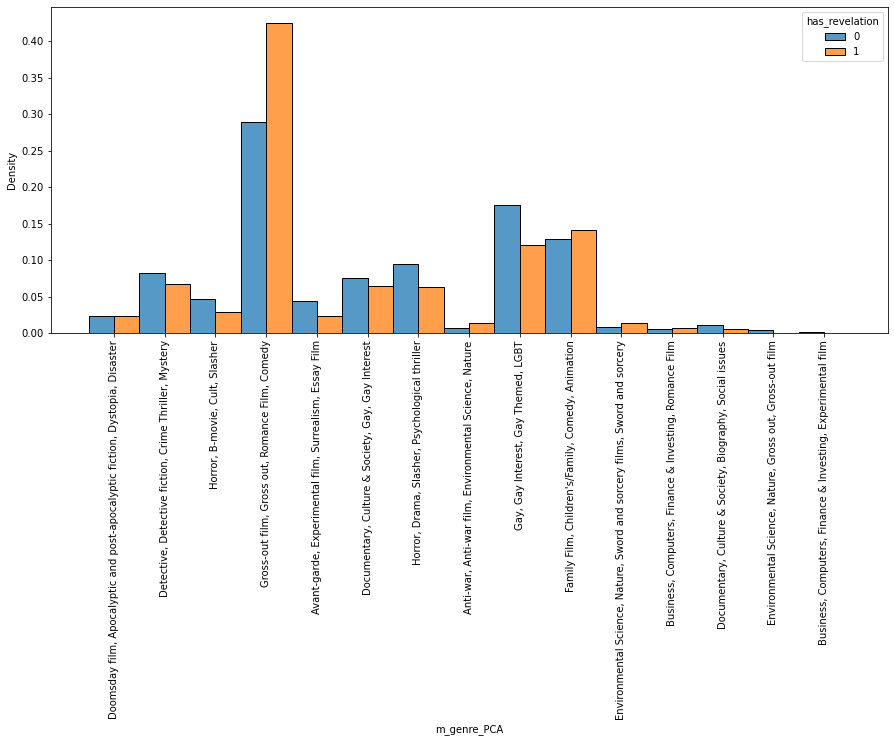

In [15]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df_movie_revelation, x='m_genre_PCA', hue='has_revelation', multiple="dodge", stat='density', common_norm=False)
plt.xticks(rotation=90);

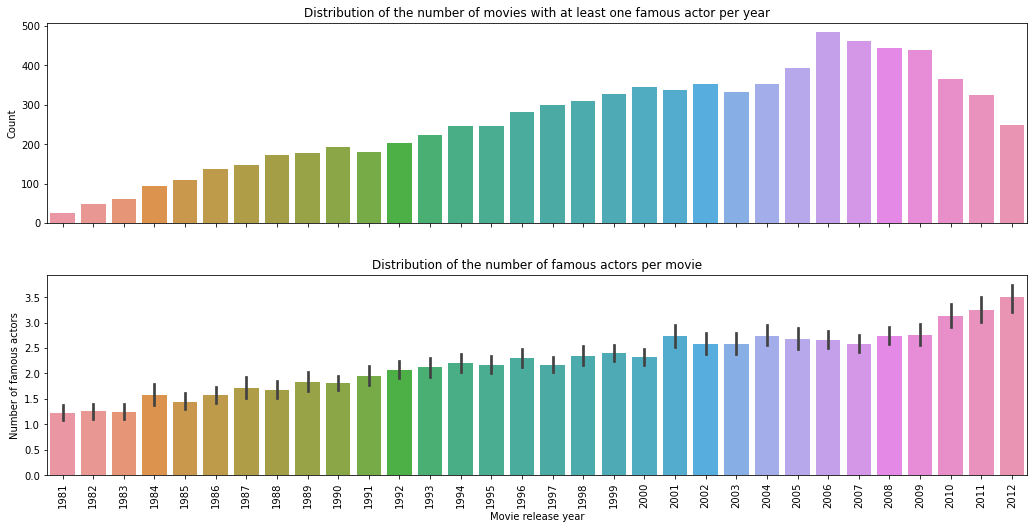

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
data_grouped = df_movie_revelation.groupby('m_release_year')['wikipedia_m_ID'].count().reset_index()
ax = axs[0]
sns.barplot(data=data_grouped,x='m_release_year', y='wikipedia_m_ID', ax=ax)
ax.set_title("Distribution of the number of movies with at least one famous actor per year")
ax.set_xlabel('')
ax.set_ylabel('Count')

ax = axs[1]
sns.barplot(data=df_movie_revelation,x='m_release_year', y='has_famous_actors', ax=ax)
ax.set_title("Distribution of the number of famous actors per movie")
plt.xticks(rotation = 90)
fig.tight_layout(pad=3.0)
ax.set_xlabel('Movie release year')
ax.set_ylabel('Number of famous actors')
plt.show()

As it can be seen, there is an increase in the number of movies per year but also a major increase in the number of famous actors per movie.
The second observation can be due to two facts:
* The global increase in the number of movies
* The scoring system: once you've been releaved, you stay famous. But the earlier we are, the less information we have about actors that were releaved before 1980 but for whom we don't have an accurate score.

For those two reasons, the time period will be split into 6 blocks, so that movies with comparable number of famous actors will be compared.

# 2.2 Revelation per pentade

In [17]:
nb_five_years_lower = range(1982, 2008,5)
nb_five_years_upper = range(1987, 2013, 5)

In [18]:
def define_popularity(min_year, lower_bound, upper_bound):
    if not min_year or min_year >= upper_bound:
        return 'unknown'
    if min_year < lower_bound:
        return 'famous'
    else:
        return 'revelation'

In [19]:
df_chars_revelation = df_movie_revelation.merge(df_chars_merged, on=['wikipedia_m_ID', 'm_release_date', 'm_genre_PCA'], how='inner').copy()
df_revelations_five_years = dict()
for y_lower, y_upper in zip(nb_five_years_lower, nb_five_years_upper):
    filter_conditions = (
        (df_chars_revelation['m_release_date'].dt.year >= y_lower) & 
        (df_chars_revelation['m_release_date'].dt.year < y_upper)
    )
    columns = ['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA','actor_name', 'is_revealed', 'already_revealed', 'min_year']
    df_filtered = df_chars_revelation.loc[filter_conditions, columns].copy()
    df_filtered['popularity'] = df_filtered['min_year'].apply(lambda x: define_popularity(x, y_lower, y_upper))
    df_revelations_five_years.update({range(y_lower, y_upper): df_filtered.copy()})

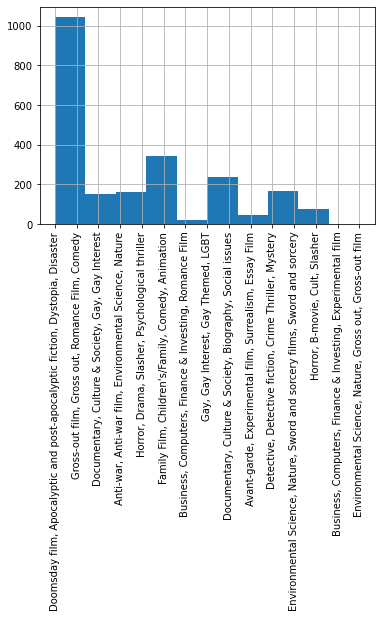

In [20]:
df_chars_revelation[df_chars_revelation['is_revealed'] == 1]['m_genre_PCA'].hist()
plt.xticks(rotation=90);

In [21]:
df_movie_revelation['m_genre_PCA'].value_counts().index[:7]

Index(['Gross-out film, Gross out, Romance Film, Comedy',
       'Gay, Gay Interest, Gay Themed, LGBT',
       'Family Film, Children's/Family, Comedy, Animation',
       'Horror, Drama, Slasher, Psychological thriller',
       'Detective, Detective fiction, Crime Thriller, Mystery',
       'Documentary, Culture & Society, Gay, Gay Interest',
       'Horror, B-movie, Cult, Slasher'],
      dtype='object')

In [22]:
df_revelations_five_years[range(1982,1987)]

,wikipedia_m_ID,m_name,m_release_date,m_genre_PCA,actor_name,is_revealed,already_revealed,min_year,popularity
0,3746,Blade Runner,1982-06-25,"Doomsday film, Apocalyptic and post-apocalypti...",William Sanderson,0,0,0,unknown
1,3746,Blade Runner,1982-06-25,"Doomsday film, Apocalyptic and post-apocalypti...",Harrison Ford,0,1,1980,famous
2,3746,Blade Runner,1982-06-25,"Doomsday film, Apocalyptic and post-apocalypti...",Rutger Hauer,0,0,1985,revelation
3,3746,Blade Runner,1982-06-25,"Doomsday film, Apocalyptic and post-apocalypti...",Sean Young,1,0,1982,revelation
4,3746,Blade Runner,1982-06-25,"Doomsday film, Apocalyptic and post-apocalypti...",Daryl Hannah,0,0,1984,revelation
...,...,...,...,...,...,...,...,...,...
85369,34152774,The Bad Seed,1985-02-07,"Horror, Drama, Slasher, Psychological thriller",Michael Beck,0,0,0,unknown
85370,34152774,The Bad Seed,1985-02-07,"Horror, Drama, Slasher, Psychological thriller",Blair Brown,0,1,1981,famous
85371,34152774,The Bad Seed,1985-02-07,"Horror, Drama, Slasher, Psychological thriller",Richard Kiley,0,0,0,unknown
85372,34152774,The Bad Seed,1985-02-07,"Horror, Drama, Slasher, Psychological thriller",Lynn Redgrave,0,0,0,unknown


In [23]:
df_chars_revelation['m_genre_PCA'].value_counts()

Gross-out film, Gross out, Romance Film, Comedy                                30539
Gay, Gay Interest, Gay Themed, LGBT                                            13038
Family Film, Children's/Family, Comedy, Animation                              12165
Horror, Drama, Slasher, Psychological thriller                                  6711
Detective, Detective fiction, Crime Thriller, Mystery                           6322
Documentary, Culture & Society, Gay, Gay Interest                               5671
Horror, B-movie, Cult, Slasher                                                  3225
Avant-garde, Experimental film, Surrealism, Essay Film                          3093
Doomsday film, Apocalyptic and post-apocalyptic fiction, Dystopia, Disaster     1909
Environmental Science, Nature, Sword and sorcery films, Sword and sorcery       1067
Documentary, Culture & Society, Biography, Social issues                         884
Anti-war, Anti-war film, Environmental Science, Nature           

In [24]:
def get_attributes(df_, graph_, previous_score):
    df_revelation = df_.merge(graph_.drop_duplicates('actor_name_x', keep='first'), left_on='actor_name', right_on='actor_name_x', how='inner')[['actor_name', 'min_year', 'popularity']]
    revelation = df_revelation.drop_duplicates(keep='first').set_index('actor_name').to_dict('index')
    
    df_famous = df_.merge(graph_.drop_duplicates('actor_name_y', keep='first'), left_on='actor_name', right_on='actor_name_y', how='inner')[['actor_name', 'min_year', 'popularity' , '{}'.format(previous_score)]]
    famous = df_famous.drop_duplicates(keep='first').set_index('actor_name').to_dict('index')
    
    attrs_ = dict()
    attrs_.update(revelation)
    attrs_.update(famous)
    
    return revelation, famous, attrs_

In [25]:
def create_bipartite_graph(revelation, famous, attrs_, graph_):
    B = nx.Graph()
    B.add_nodes_from(revelation, bipartite=0)
    B.add_nodes_from(famous, bipartite=1)
    B.add_weighted_edges_from([(row['actor_name_x'], row['actor_name_y'], 1) for idx, row in graph_.iterrows()], weight='weight')

    colors = []
    for node in B:
        val = attrs_[node]['popularity']
        if val =='revelation':
            colors.append("green")
        elif val =='famous':
            colors.append("red")
        else:
            colors.append("gray")
    
    pos = {node:[0, i] for i,node in enumerate(revelation.keys())}
    pos.update({node:[1, i] for i,node in enumerate(famous.keys())})
    
    bipartite_graph = {'graph': B, 'pos': pos, 'node_color':colors}
    
    return bipartite_graph

In [26]:
def extract_partition_nodes(G: nx.Graph, attrs_, partition: str):
    nodeset = [x for x in G.nodes if attrs_[x]['popularity'] == partition]
    if partition != "revelation" and partition!="famous":
        raise Exception(f"No nodes exist in the partition {partition}!")
    return nodeset

In [92]:
def retrieve_career_boosters(graph_, previous_score, attrs_):
    revelations_ = extract_partition_nodes(graph_,attrs_, "revelation")
    famous_ = extract_partition_nodes(graph_, attrs_, "famous")
    
    sources = revelations_
    targets = revelations_
    measures = dict()
    measures=['betweenness_centrality_subset', 'degree_centrality']
    
    bc_subset = nx.betweenness_centrality_subset(graph_, sources=sources, targets=targets)
    dc_subset = nx.degree_centrality(graph_)
    
    sorted_bc = sorted(bc_subset.items(), key=lambda kv: kv[1], reverse=True)
    sorted_dc = sorted(dc_subset.items(), key=lambda kv: kv[1], reverse=True)
    career_boosters_bc = []
    career_boosters_dc = []
    for (x, m) in sorted_bc:
        if attrs_[x]['popularity']=='famous':
            score = attrs_[x]['{}'.format(previous_score)]
            min_year = attrs_[x]['min_year']
            bc_measure = m
            cc_measure = dc_subset[x]
            famous_actor = {'actor_name':x, 'score_in_{}'.format(previous_score):score, 'revealed_in':min_year, 'betweenness_centrality_subset':bc_measure, 'degree_centrality':cc_measure}
            career_boosters_bc.append(famous_actor)
    for (x, m) in sorted_dc:
        if attrs_[x]['popularity']=='famous':
            score = attrs_[x]['{}'.format(previous_score)]
            min_year = attrs_[x]['min_year']
            bc_measure = bc_subset[x]
            cc_measure = m
            famous_actor = {'actor_name':x, 'score_in_{}'.format(previous_score):score, 'revealed_in':min_year, 'betweenness_centrality_subset':bc_measure, 'degree_centrality':cc_measure}
            career_boosters_dc.append(famous_actor)
    
    return career_boosters_bc, career_boosters_dc

In [93]:
def compute_career_boosters_infos(df_, graph_, range_y, m_genre):
    career_booster_infos = dict()
    for i, x in enumerate(df_[:5], start=1):
        key = x['actor_name']
        score = x['score_in_{}'.format(range_y.start-1)]
        min_year = x['revealed_in']
        ranking = i
        bc_measure = x['betweenness_centrality_subset']
        dc_measure = x['degree_centrality']
        casting = graph_[graph_['actor_name_y'] == key]
        nb_actors_boosted_at_revelation = casting[casting['is_revealed_x'] == 1].shape[0]
        nb_actors_boosted_before_revelation = casting[casting['is_revealed_x'] == 0].shape[0]
        nb_actors_boosted = casting.shape[0]
        tmp_booster = {'booster_in': range_y,
                       'm_genre': m_genre,
                       'ranking': i,
                       'betweenness_centrality_subset': bc_measure,
                       'degree_centrality': dc_measure,
                       'actor_score_before_period': score,
                       'nb_actors_boosted': nb_actors_boosted,
                       'nb_actors_boosted_at_revelation': nb_actors_boosted_at_revelation,
                       'nb_actors_boosted_before_revelation': nb_actors_boosted_before_revelation
        }
        career_booster_infos.update({key: tmp_booster})
    career_boosters_info_df = pd.DataFrame.from_dict(career_booster_infos, orient='index')
    return career_boosters_info_df

In [96]:
def carreer_booster_retrieval_for_all_genres():

    graphs = dict()
    famous_ranking_bc = dict()
    famous_ranking_dc = dict()
    booster_bc = dict()
    booster_dc = dict()

    for y_lower, y_upper in zip(nb_five_years_lower, nb_five_years_upper):
        tmp_range = range(y_lower, y_upper)
        df_tmp = df_revelations_five_years[tmp_range].copy()
        df_tmp = df_tmp.merge(df_numbers[['actor_name', '{}'.format(y_lower-1)]], on='actor_name', how='left')
        df_tmp['{}'.format(y_lower-1)] = df_tmp['{}'.format(y_lower-1)].fillna(0)

        graph = pd.merge(df_tmp, df_tmp, on=['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA'])
        filter_conditions = (
            (graph.popularity_x == 'revelation') & 
            (graph.popularity_y == 'famous') &
            (graph.m_release_date.dt.year <= graph.min_year_x)
        )
        graph = graph.loc[filter_conditions]
        #print(df_tmp)
        
        unique_genres = df_tmp['m_genre_PCA'].unique()
        genre_iteration = ['all'] + list(unique_genres)
        
        graphs_genre = dict()
        famous_ranking_bc_genre = dict()
        famous_ranking_dc_genre = dict()
        booster_bc_genre = dict()
        booster_dc_genre = dict()
        
        for genre in genre_iteration:
            graph_genre = graph.copy()
            df_genre = df_tmp.copy()
            #print(genre)
            if genre !='all':
                #print("there")
                filter_conditions = (
                    (graph_genre.m_genre_PCA == genre)
                )
                graph_genre = graph.loc[filter_conditions]
                filter_conditions = (
                    (df_genre.m_genre_PCA == genre)
                )
                df_genre = df_genre.loc[filter_conditions]
            #print(df_genre)
            revelation_attributes, famous_attributes, attrs = get_attributes(df_genre, graph_genre, y_lower-1)
            #print(attrs)

            tmp_graph = create_bipartite_graph(revelation_attributes, famous_attributes, attrs, graph_genre)
            graphs_genre.update({genre: tmp_graph})
            #print(tmp_graph)

            tmp_famous_ranking_bc, tmp_famous_ranking_dc = retrieve_career_boosters(tmp_graph['graph'], y_lower-1, attrs)
            famous_ranking_bc_genre.update({genre: tmp_famous_ranking_bc})
            famous_ranking_dc_genre.update({genre: tmp_famous_ranking_dc})

            tmp_career_booster_bc = compute_career_boosters_infos(tmp_famous_ranking_bc[:5], graph_genre, tmp_range, genre)
            booster_bc_genre.update({genre: tmp_career_booster_bc})

            tmp_career_booster_dc = compute_career_boosters_infos(tmp_famous_ranking_dc[:5], graph_genre, tmp_range, genre)
            booster_dc_genre.update({genre: tmp_career_booster_dc})
            
        graphs.update({tmp_range: graphs_genre})
        famous_ranking_bc.update({tmp_range: famous_ranking_bc_genre})
        famous_ranking_dc.update({tmp_range: famous_ranking_dc_genre})
        booster_bc.update({tmp_range: booster_bc_genre})
        booster_dc.update({tmp_range: booster_dc_genre})
        
    return booster_bc, booster_dc


In [97]:
career_booster_bc = dict()
career_booster_dc = dict()

career_booster_bc, career_booster_dc = carreer_booster_retrieval_for_all_genres()

In [100]:
career_booster_bc

{range(1982, 1987): {'all':                                     booster_in m_genre  ranking  \
  Dennis Quaid    (1982, 1983, 1984, 1985, 1986)     all        1   
  Dan Aykroyd     (1982, 1983, 1984, 1985, 1986)     all        2   
  Chevy Chase     (1982, 1983, 1984, 1985, 1986)     all        3   
  William Hurt    (1982, 1983, 1984, 1985, 1986)     all        4   
  Robin Williams  (1982, 1983, 1984, 1985, 1986)     all        5   
  
                  betweenness_centrality_subset  degree_centrality  \
  Dennis Quaid                      1124.359258           0.087838   
  Dan Aykroyd                        938.580864           0.060811   
  Chevy Chase                        859.911077           0.081081   
  William Hurt                       765.724702           0.060811   
  Robin Williams                     583.056702           0.033784   
  
                  actor_score_before_period  nb_actors_boosted  \
  Dennis Quaid                        250.0                 13   
  

In [101]:
career_boosters_ids = 'career_boosters_ids.csv'

with open(career_boosters_ids, 'w') as f:
    writer = csv.writer(f)
    for key_year, val_year in career_booster_dc.items():
        for key_genre, val_genre in val_year.items():
            name_genre = key_genre.replace(' ', '_')
            name_genre = ''.join(item for item in name_genre if (item.isalnum() or item=='_'))
            row = [key_year.start, key_year.stop-1, name_genre]
            # write a row to the csv file
            writer.writerow(row)

In [99]:
for key_year, val_year in career_booster_cc.items():
    for key_genre, val_genre in val_year.items():
        print(val_genre.head())
        #val_genre.plot()

In [102]:
CAREER_BOOSTER_PATH = "./career_boosters"
for key_year, val_year in career_booster_dc.items():
    for key_genre, val_genre in val_year.items():
        name_genre = key_genre.replace(' ', '_')
        name_genre = ''.join(item for item in name_genre if (item.isalnum() or item=='_'))
        name_pkl = "career_booster_dc_{}_{}_genre_{}.pkl".format(key_year.start, key_year.stop-1, name_genre)
        OUTPUT_PKL = os.path.join(CAREER_BOOSTER_PATH, name_pkl)
        val_genre.to_pickle(OUTPUT_PKL)

./career_boosters\career_booster_dc_1982_1986_genre_all.pkl
./career_boosters\career_booster_dc_1982_1986_genre_Doomsday_film_Apocalyptic_and_postapocalyptic_fiction_Dystopia_Disaster.pkl
./career_boosters\career_booster_dc_1982_1986_genre_Detective_Detective_fiction_Crime_Thriller_Mystery.pkl
./career_boosters\career_booster_dc_1982_1986_genre_Grossout_film_Gross_out_Romance_Film_Comedy.pkl
./career_boosters\career_booster_dc_1982_1986_genre_Horror_Drama_Slasher_Psychological_thriller.pkl
./career_boosters\career_booster_dc_1982_1986_genre_Family_Film_ChildrensFamily_Comedy_Animation.pkl
./career_boosters\career_booster_dc_1982_1986_genre_Documentary_Culture__Society_Gay_Gay_Interest.pkl
./career_boosters\career_booster_dc_1982_1986_genre_Gay_Gay_Interest_Gay_Themed_LGBT.pkl
./career_boosters\career_booster_dc_1982_1986_genre_Antiwar_Antiwar_film_Environmental_Science_Nature.pkl
./career_boosters\career_booster_dc_1982_1986_genre_Environmental_Science_Nature_Sword_and_sorcery_films_Sw

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(20, 15))
for i, year in enumerate(graphs):
    G = graphs[year]['graph']
    pos = graphs[year]['pos']
    node_color = graphs[year]['node_color']
    #ix = np.unravel_index(i, axs.shape)
    #plt.sca(axs[ix])
    nx.draw(G, pos=pos, node_color=node_color, with_labels=False, node_size=10, ax=axs[i])
    axs[i].set_title("Period: {}-{}".format(year.start, year.stop))
    
fig.suptitle('Graph of the relations between revelation actors (in green) and famous actors (in red) before the first are revealed')

plt.scatter([],[], c=['green'], label='Revelations')
plt.scatter([],[], c=['red'], label='Famous actors')

plt.legend()
plt.show()

fig.tight_layout()

In [ ]:
for k_year, v_year in career_booster.items():
    print("\nRESULTS FOR PERIOD: {}-{}".format(k_year.start, k_year.stop))
    print ("{:<5}: {:<18} {:<6} {:<17} {:<32} {:<5}".format('rank', 'name', 'score', 'nb_actors_boosted', 'nb_actors_boosted_at_revelation', 'nb_actors_boosted_before_revelation'))
    for k_actor, v_actor in v_year.items():
        boosted_in, ranking, actor_score_before_period, nb_actors_boosted, nb_actors_boosted_at_revelation, nb_actors_boosted_before_revelation = v_actor.values()
        print ("{:<5}: {:<18} {:<6} {:<17} {:<32} {:<5}".format(ranking, k_actor, round(actor_score_before_period), nb_actors_boosted, nb_actors_boosted_at_revelation, nb_actors_boosted_before_revelation))